# SARIMAX and ARIMA: Frequently Asked Questions (FAQ)

This notebook contains explanations for frequently asked questions.

* Comparing trends and exogenous variables in `SARIMAX`, `ARIMA` and `AutoReg`
* Reconstructing residuals, fitted values and forecasts in `SARIMAX` and `ARIMA`
* Initial residuals in `SARIMAX` and `ARIMA`

## Comparing trends and exogenous variables in `SARIMAX`, `ARIMA` and `AutoReg`

`ARIMA` are formally OLS with ARMA errors.  A basic AR(1) in the OLS with ARMA errors is described as 

$$
\begin{align}
Y_t & = \delta + \epsilon_t \\
\epsilon_t & = \rho \epsilon_{t-1} + \eta_t \\
\eta_t & \sim WN(0,\sigma^2) \\
\end{align}
$$

In large samples, $\hat{\delta}\stackrel{p}{\rightarrow} E[Y]$.

`SARIMAX` uses a different representation, so that the model when estimated using `SARIMAX` is

$$
\begin{align}
Y_t & = \phi + \rho Y_{t-1} + \eta_t \\
\eta_t & \sim WN(0,\sigma^2) \\
\end{align}
$$


This is the same representation that is used when the model is estimated using OLS (`AutoReg`). In large samples, $\hat{\phi}\stackrel{p}{\rightarrow} E[Y](1-\rho)$.

In the next cell, we simulate a large sample and verify that these relationship hold in practice.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(20210819)
eta = rng.standard_normal(5200)
rho = 0.8
beta = 10
epsilon = eta.copy()
for i in range(1, eta.shape[0]):
    epsilon[i] = rho * epsilon[i - 1] + eta[i]
y = beta + epsilon
y = y[200:]

In [3]:
from statsmodels.tsa.api import SARIMAX, AutoReg
from statsmodels.tsa.arima.model import ARIMA

The three models are specified and estimated in the next cell.  An AR(0) is included as a reference. The AR(0) is identical using all three estimators.

In [4]:
ar0_res = SARIMAX(y, order=(0, 0, 0), trend="c").fit()
sarimax_res = SARIMAX(y, order=(1, 0, 0), trend="c").fit()
arima_res = ARIMA(y, order=(1, 0, 0), trend="c").fit()
autoreg_res = AutoReg(y, 1, trend="c").fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91760D+00    |proj g|=  3.68860D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   3.689D-06   1.918D+00
  F =   1.9175996129577773     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41373D+00    |proj g|=  9.51828D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      5      1     0     0   4.516D-05   1.414D+00
  F =   1.4137311050015484     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


The table below contains the estimated parameter in the model, the estimated AR(1) coefficient, and the long-run mean which is either equal to the estimated parameters (AR(0) or `ARIMA`), or depends on the ratio of the intercept to 1 minus the AR(1) parameter.

In [5]:
intercept = [
    ar0_res.params[0],
    sarimax_res.params[0],
    arima_res.params[0],
    autoreg_res.params[0],
]
rho_hat = [0] + [r.params[1] for r in (sarimax_res, arima_res, autoreg_res)]
long_run = [
    ar0_res.params[0],
    sarimax_res.params[0] / (1 - sarimax_res.params[1]),
    arima_res.params[0],
    autoreg_res.params[0] / (1 - autoreg_res.params[1]),
]
cols = ["AR(0)", "SARIMAX", "ARIMA", "AutoReg"]
pd.DataFrame(
    [intercept, rho_hat, long_run],
    columns=cols,
    index=["delta-or-phi", "rho", "long-run mean"],
)

,AR(0),SARIMAX,ARIMA,AutoReg
delta-or-phi,9.7745,1.985714,9.774498,1.985790
rho,0.0000,0.796846,0.796875,0.796882
long-run mean,9.7745,9.774424,9.774498,9.776537


### Differences between trend and exog in `SARIMAX`

When `SARIMAX` includes `exog` variables, then the `exog` are treated as OLS regressors, so that the model estimated is

$$
\begin{align}
Y_t - X_t \beta & = \delta + \rho (Y_{t-1} - X_{t-1}\beta) + \eta_t \\
\eta_t & \sim WN(0,\sigma^2) \\
\end{align}
$$

In the next example, we omit the trend and instead include a column of 1, which produces a model that is equivalent, in large samples, to the case with no exogenous regressor and `trend="c"`. Here the estimated value of `const` matches the value estimated using `ARIMA`. This happens since both exog in `SARIMAX` and the trend in `ARIMA` are treated as linear regression models with ARMA errors.

In [6]:
sarimax_exog_res = SARIMAX(y, exog=np.ones_like(y), order=(1, 0, 0), trend="n").fit()
print(sarimax_exog_res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41373D+00    |proj g|=  1.06920D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1      4      1     0     0   4.752D-05   1.414D+00
  F =   1.4137311099487531     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5000
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -7068.656
Date:                Sat, 25 May 2024   AIC                          14143.311
Time:                        05:25:35   BIC                          14162.863
Sample:                             0   HQIC                         14150.164
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7745      0.069    141.177      0.000       9.639       9.910
ar.L1          0.7969      0.009     93.691      0.000       0.780       0.814
sigma2         0.9894      0.020     49.921      0.0

### Using `exog` in `SARIMAX` and `ARIMA`

While `exog` are treated the same in both models, the intercept continues to differ.  Below we add an exogenous regressor to `y` and then fit the model using all three methods. The data generating process is now

$$
\begin{align}
Y_t & = \delta + X_t \beta + \epsilon_t \\
\epsilon_t & = \rho \epsilon_{t-1} + \eta_t \\
\eta_t & \sim WN(0,\sigma^2) \\
\end{align}
$$


In [7]:
full_x = rng.standard_normal(eta.shape)
x = full_x[200:]
y += 3 * x

In [8]:
sarimax_exog_res = SARIMAX(y, exog=x, order=(1, 0, 0), trend="c").fit()
arima_exog_res = ARIMA(y, exog=x, order=(1, 0, 0), trend="c").fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42683D+00    |proj g|=  2.05943D-01


 This problem is unconstrained.



At iterate    5    f=  1.41332D+00    |proj g|=  1.60874D-03



At iterate   10    f=  1.41329D+00    |proj g|=  3.11659D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   1.796D-06   1.413D+00
  F =   1.4132928400115858     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


Examining the parameter tables, we see that the parameter estimates on `x1` are identical while the estimates of the `intercept` continue to differ due to the differences in the treatment of trends in these estimators.

#### `SARIMAX`

In [9]:
def print_params(s):
    from io import StringIO

    return pd.read_csv(StringIO(s.tables[1].as_csv()), index_col=0)


print_params(sarimax_exog_res.summary())

,coef,std err,z,P>|z|,[0.025,0.975]
,,,,,,
intercept,1.9849,0.085,23.484,0.0,1.819,2.151
x1,3.0231,0.011,277.150,0.0,3.002,3.044
ar.L1,0.7969,0.009,93.735,0.0,0.780,0.814
sigma2,0.9886,0.020,49.941,0.0,0.950,1.027


#### `ARIMA`

In [10]:
print_params(arima_exog_res.summary())

,coef,std err,z,P>|z|,[0.025,0.975]
,,,,,,
const,9.7741,0.069,141.201,0.0,9.638,9.910
x1,3.0231,0.011,277.140,0.0,3.002,3.044
ar.L1,0.7969,0.009,93.728,0.0,0.780,0.814
sigma2,0.9886,0.020,49.941,0.0,0.950,1.027


### `exog` in `AutoReg`

When using `AutoReg` to estimate a model using OLS, the model differs from both `SARIMAX` and `ARIMA`. The `AutoReg` specification with exogenous variables is 

$$
\begin{align}
Y_t & = \phi + \rho Y_{t-1} + X_{t}\beta + \eta_t \\
\eta_t & \sim WN(0,\sigma^2) \\
\end{align}
$$

This specification is not equivalent to the specification estimated in `SARIMAX` and `ARIMA`. Here the difference is non-trivial, and naive estimation on the same time series results in different parameter values, even in large samples (and the limit). Estimating this model changes the parameter estimates on the AR(1) coefficient.

#### `AutoReg`

In [11]:
autoreg_exog_res = AutoReg(y, 1, exog=x, trend="c").fit()
print_params(autoreg_exog_res.summary())

,coef,std err,z,P>|z|,[0.025,0.975]
,,,,,,
const,7.9714,0.064,124.525,0.0,7.846,8.097
y.L1,0.1838,0.006,29.890,0.0,0.172,0.196
x1,3.0311,0.021,142.513,0.0,2.989,3.073


The key difference can be seen by writing the model in lag operator notation.

$$
\begin{align}
(1-\phi L ) Y_t & = X_{t}\beta + \eta_t \Rightarrow \\
Y_t & = (1-\phi L )^{-1}\left(X_{t}\beta + \eta_t\right) \\
Y_t & = \sum_{i=0}^{\infty} \phi^i \left(X_{t-i}\beta + \eta_{t-i}\right)
\end{align}
$$

where it is is assumed that $|\phi|<1$.  Here we see that $Y_t$ depends on all lagged values of $X_t$ and $\eta_t$.  This differs from the specification estimated by `SARIMAX` and `ARIMA`, which can be seen to be

$$
\begin{align}
Y_t - X_t \beta & = \delta + \rho (Y_{t-1} - X_{t-1}\beta) + \eta_t \\
\left(1-\rho L \right)\left(Y_t - X_t  \beta\right) & = \delta +  \eta_t \\
Y_t - X_t  \beta & = \frac{\delta}{1-\rho} +  \left(1-\rho L \right)^{-1}\eta_t \\
Y_t - X_t  \beta & = \frac{\delta}{1-\rho} +  \sum_{i=0}^\infty \rho^i \eta_{t-i} \\
Y_t  & = \frac{\delta}{1-\rho} + X_t  \beta +  \sum_{i=0}^\infty \rho^i \eta_{t-i} \\
\end{align}
$$

In this specification, $Y_t$ only depends on $X_t$ and no other lags.

### Using the correct DGP with `AutoReg`

Simulating the process that is estimated in `AutoReg` shows that the parameters are recovered from the true model. 

In [12]:
y = beta + eta
epsilon = eta.copy()
for i in range(1, eta.shape[0]):
    y[i] = beta * (1 - rho) + rho * y[i - 1] + 3 * full_x[i] + eta[i]
y = y[200:]

#### `AutoReg` with correct DGP

In [13]:
autoreg_alt_exog_res = AutoReg(y, 1, exog=x, trend="c").fit()
print_params(autoreg_alt_exog_res.summary())

,coef,std err,z,P>|z|,[0.025,0.975]
,,,,,,
const,1.9870,0.030,66.526,0.0,1.928,2.046
y.L1,0.7968,0.003,300.382,0.0,0.792,0.802
x1,3.0263,0.014,217.034,0.0,2.999,3.054


## Reconstructing residuals, fitted values and forecasts in `SARIMAX` and `ARIMA`

In models that contain only autoregressive terms, trends and exogenous variables, fitted values and forecasts can be easily reconstructed once the maximum lag length in the model has been reached.  In practice, this means after $(P+D)s+p+d$ periods. Earlier predictions and residuals are harder to reconstruct since the model builds the best prediction for $Y_t|Y_{t-1},Y_{t-2},...$.  When the number of lags of $Y$ is less than the autoregressive order, then the expression for the optimal prediction differs from the model.  For example, when predicting the very first value, $Y_1$, there is no information available from the history of $Y$, and so the best prediction is the unconditional mean. In the case of an AR(1), the second prediction will follow the model, so that when using `ARIMA`, the prediction is

$$
Y_2 = \hat{\delta} + \hat{\rho} \left(Y_1 - \hat{\delta}\right)
$$

since `ARIMA` treats both exogenous and trend terms as regression with ARMA errors.

This can be seen in the next set of cells.

In [14]:
arima_res = ARIMA(y, order=(1, 0, 0), trend="c").fit()
print_params(arima_res.summary())

,coef,std err,z,P>|z|,[0.025,0.975]
,,,,,,
const,9.9346,0.222,44.667,0.0,9.499,10.371
ar.L1,0.7957,0.009,92.515,0.0,0.779,0.813
sigma2,10.3015,0.204,50.496,0.0,9.902,10.701


In [15]:
arima_res.predict(0, 2)

array([ 9.93458658, 10.91088035, 11.80415747])

In [16]:
delta_hat, rho_hat = arima_res.params[:2]
delta_hat + rho_hat * (y[0] - delta_hat)

10.910880346250012

`SARIMAX` treats trend terms differently, and so the one-step forecast from a model estimated using `SARIMAX` is

$$
Y_2 = \hat\delta + \hat\rho Y_1
$$

In [17]:
sarima_res = SARIMAX(y, order=(1, 0, 0), trend="c").fit()
print_params(sarima_res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58518D+00    |proj g|=  5.99456D-05


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   3.347D-05   2.585D+00
  F =   2.5851830060985752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


,coef,std err,z,P>|z|,[0.025,0.975]
,,,,,,
intercept,2.0283,0.097,20.841,0.0,1.838,2.219
ar.L1,0.7959,0.009,92.536,0.0,0.779,0.813
sigma2,10.3007,0.204,50.500,0.0,9.901,10.700


In [18]:
sarima_res.predict(0, 2)

array([ 9.93588659, 10.91128867, 11.80469658])

In [19]:
delta_hat, rho_hat = sarima_res.params[:2]
delta_hat + rho_hat * y[0]

10.911288670367867

### Prediction with MA components

When a model contains a MA component, the prediction is more complicated since errors are never directly observable.  The prediction is still $Y_t|Y_{t-1},Y_{t-2},...$, and when the MA component is invertible, then the optimal prediction can be represented as a $t$-lag AR process. When $t$ is large, this should be very close to the prediction as if the errors were observable. For short lags, this can differ markedly.

In the next cell we simulate an MA(1) process, and fit an MA model.

In [20]:
rho = 0.8
beta = 10
epsilon = eta.copy()
for i in range(1, eta.shape[0]):
    epsilon[i] = rho * eta[i - 1] + eta[i]
y = beta + epsilon
y = y[200:]

ma_res = ARIMA(y, order=(0, 0, 1), trend="c").fit()
print_params(ma_res.summary())

,coef,std err,z,P>|z|,[0.025,0.975]
,,,,,,
const,9.9185,0.025,391.129,0.0,9.869,9.968
ma.L1,0.8025,0.009,93.864,0.0,0.786,0.819
sigma2,0.9904,0.020,49.925,0.0,0.951,1.029


We start by looking at predictions near the beginning of the sample corresponding `y[1]`, ..., `y[5]`.

In [21]:
ma_res.predict(1, 5)

array([ 8.57011015,  9.19907188,  8.96971353,  9.78987115, 11.11984478])

and the corresponding residuals that are needed to produce the "direct" forecasts

In [22]:
ma_res.resid[:5]

array([-2.7621904 , -1.12255005, -1.33557621, -0.17206944,  1.5634041 ])

Using the model parameters, we can produce the "direct" forecasts using the MA(1) specification

$$
\hat Y_t = \hat\delta + \hat\rho \hat\epsilon_{t-1}
$$

We see that these are not especially close to the actual model predictions for the initial forecasts, but that the gap quickly reduces.

In [23]:
delta_hat, rho_hat = ma_res.params[:2]
direct = delta_hat + rho_hat * ma_res.resid[:5]
direct

array([ 7.70168405,  9.01756049,  8.84659855,  9.7803589 , 11.17314527])

The difference is nearly a standard deviation for the first but declines as the index increases.

In [24]:
ma_res.predict(1, 5) - direct

array([ 0.8684261 ,  0.18151139,  0.12311499,  0.00951225, -0.05330049])

We next look at the end of the sample and the final three predictions.

In [25]:
t = y.shape[0]
ma_res.predict(t - 3, t - 1)

array([ 9.79692804, 10.51272714, 10.55855562])

In [26]:
ma_res.resid[-4:-1]

array([-0.15142355,  0.74049384,  0.79759816])

In [27]:
direct = delta_hat + rho_hat * ma_res.resid[-4:-1]
direct

array([ 9.79692804, 10.51272714, 10.55855562])

The "direct" forecasts are identical. This happens since the effect of the short sample has disappeared by the end of the sample (In practice it is negligible by observations 100 or so, and numerically absent by around observation 160).

In [28]:
ma_res.predict(t - 3, t - 1) - direct

array([0., 0., 0.])

The same principle applies in more complicated model that include multiple lags or seasonal term - predictions in AR models are simple once the effective lag length has been reached, while predictions in models that contains MA components are only simple once the maximum root of the MA lag polynomial is sufficiently small so that the residuals are close to the true residuals. 

### Prediction differences in `SARIMAX` and `ARIMA`

The formulas used to make predictions from `SARIMAX` and `ARIMA` models differ in one key aspect - `ARIMA` treats all trend terms, e.g, the intercept or time trend, as part of the exogenous regressors.  For example, an AR(1) model with an intercept and linear time trend estimated using `ARIMA` has the specification

$$
\begin{align*}
Y_t - \delta_0 - \delta_1 t & = \epsilon_t \\
\epsilon_t & = \rho \epsilon_{t-1} + \eta_t
\end{align*}
$$

When the same model is estimated using `SARIMAX`, the specification is 

$$
\begin{align*}
Y_t & = \epsilon_t \\
\epsilon_t & =  \delta_0 + \delta_1 t  + \rho \epsilon_{t-1} + \eta_t
\end{align*}
$$

The differences are more apparent when the model contains exogenous regressors, $X_t$.  The `ARIMA` specification is

$$
\begin{align*}
Y_t - \delta_0 - \delta_1 t - X_t \beta & = \epsilon_t \\
\epsilon_t & = \rho \epsilon_{t-1} + \eta_t \\
           & = \rho \left(Y_{t-1} - \delta_0 - \delta_1 (t-1) - X_{t-1} \beta\right) + \eta_t
\end{align*}
$$

while the `SARIMAX` specification is 

$$
\begin{align*}
Y_t & =  X_t \beta + \epsilon_t \\
\epsilon_t & =  \delta_0 + \delta_1 t  + \rho \epsilon_{t-1} + \eta_t \\
           & = \delta_0 + \delta_1 t  + \rho \left(Y_{t-1} - X_{t-1}\beta\right) + \eta_t
\end{align*}
$$

The key difference between these two is that the intercept and the trend are effectively equivalent to exogenous regressions in `ARIMA` while they are more like standard ARMA terms in `SARIMAX`.

The next cell simulates an ARX with a time trend using the specification in `ARIMA` and estimates the parameters using both estimators.

In [29]:
rho = 0.8
beta = 2
delta0 = 10
delta1 = 0.5
epsilon = eta.copy()
for i in range(1, eta.shape[0]):
    epsilon[i] = rho * epsilon[i - 1] + eta[i]
t = np.arange(epsilon.shape[0])
y = delta0 + delta1 * t + beta * full_x + epsilon
y = y[200:]

In [30]:
start = np.array([110, delta1, beta, rho, 1])
arx_res = ARIMA(y, exog=x, order=(1, 0, 0), trend="ct").fit()
mod = SARIMAX(y, exog=x, order=(1, 0, 0), trend="ct")
start[:2] *= 1 - rho
sarimax_res = mod.fit(start_params=start, method="bfgs")

/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 1.413691
         Iterations: 43
         Function evaluations: 72
         Gradient evaluations: 62


The two estimators fit similarly, although there is a small difference in the log-likelihood.  This is a numerical issue and should not materially affect the predictions. Importantly the two trend parameters, `const` and `x1` (unfortunately named for the time trend), differ between the two.  The other parameters are effectively identical.

In [31]:
print(arx_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7069.171
Date:                Sat, 25 May 2024   AIC                          14148.343
Time:                        05:26:01   BIC                          14180.928
Sample:                             0   HQIC                         14159.763
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        109.2112      0.137    796.186      0.000     108.942     109.480
x1             0.5000   4.78e-05   1.05e+04      0.000       0.500       0.500
x2             2.0495      0.011    187.517      0.0

In [32]:
print(sarimax_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5000
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -7068.457
Date:                Sat, 25 May 2024   AIC                          14146.914
Time:                        05:26:02   BIC                          14179.500
Sample:                             0   HQIC                         14158.335
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     22.7438      0.929     24.481      0.000      20.923      24.565
drift          0.1019      0.004     23.985      0.000       0.094       0.110
x1             2.0230      0.011    185.290      0.0

## Initial residuals `SARIMAX` and `ARIMA`

Residuals for observations before the maximal model order, which depends on the AR, MA, Seasonal AR, Seasonal MA and differencing parameters, are not reliable and should not be used for performance assessment. In general, in an ARIMA with orders $(p,d,q)\times(P,D,Q,s)$, the formula for residuals that are less well behaved is:

$$
\max((P+D)s+p+d,Qs+q)
$$

We can simulate some data from an ARIMA(1,0,0)(1,0,0,12) and examine the residuals.

In [33]:
import numpy as np
import pandas as pd

rho = 0.8
psi = -0.6
beta = 20
epsilon = eta.copy()
for i in range(13, eta.shape[0]):
    epsilon[i] = (
        rho * epsilon[i - 1]
        + psi * epsilon[i - 12]
        - (rho * psi) * epsilon[i - 13]
        + eta[i]
    )
y = beta + epsilon
y = y[200:]

With a large sample, the parameter estimates are very close to the DGP parameters.

In [34]:
res = ARIMA(y, order=(1, 0, 0), trend="c", seasonal_order=(1, 0, 0, 12)).fit()
print(res.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                 5000
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood               -7076.266
Date:                          Sat, 25 May 2024   AIC                          14160.532
Time:                                  05:26:11   BIC                          14186.600
Sample:                                       0   HQIC                         14169.668
                                         - 5000                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.8586      0.043    458.609      0.000      19.774      19.943
ar.L1          0.7972      0.008     93.925      0.

We can first examine the initial 13 residuals by plotting against the actual shocks in the model.  While there is a correspondence, it is fairly weak and the correlation is much less than 1.

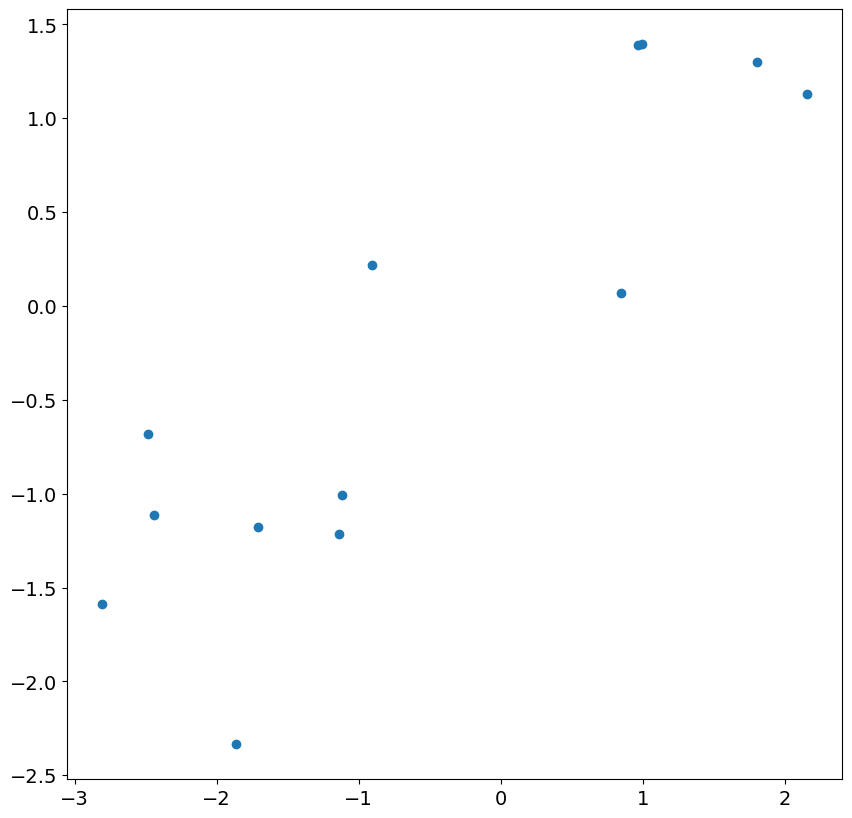

In [35]:
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=14)

_ = plt.scatter(res.resid[:13], eta[200 : 200 + 13])

Looking at the next 24 residuals and shocks, we see there is nearly perfect correlation. This is expected in large samples once the less accurate residuals are ignored.

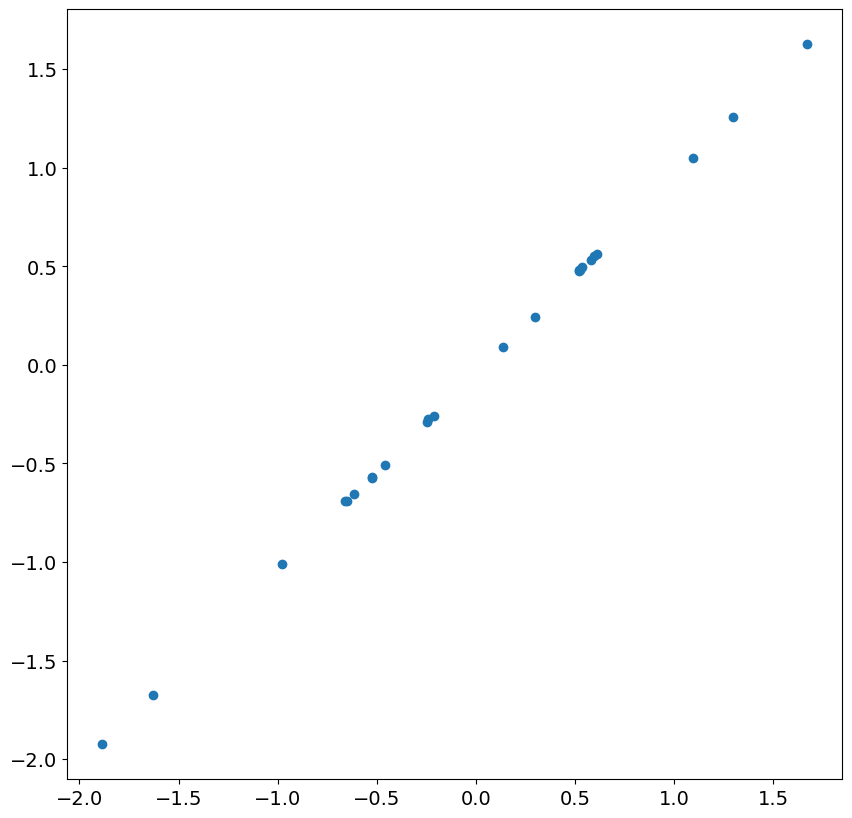

In [36]:
_ = plt.scatter(res.resid[13:37], eta[200 + 13 : 200 + 37])

Next, we simulate an ARIMA(1,1,0), and include a time trend.

In [37]:
rng = np.random.default_rng(20210819)
eta = rng.standard_normal(5200)
rho = 0.8
beta = 20
epsilon = eta.copy()
for i in range(2, eta.shape[0]):
    epsilon[i] = (1 + rho) * epsilon[i - 1] - rho * epsilon[i - 2] + eta[i]
t = np.arange(epsilon.shape[0])
y = beta + 2 * t + epsilon
y = y[200:]

Again the parameter estimates are very close to the DGP parameters.

In [38]:
res = ARIMA(y, order=(1, 1, 0), trend="t").fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5000
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -7067.739
Date:                Sat, 25 May 2024   AIC                          14141.479
Time:                        05:26:13   BIC                          14161.030
Sample:                             0   HQIC                         14148.331
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7747      0.069     25.642      0.000       1.639       1.910
ar.L1          0.7968      0.009     93.658      0.000       0.780       0.813
sigma2         0.9896      0.020     49.908      0.0

The residuals are not accurate, and the first residual is approximately 500.  The others are closer, although in this model the first 2 should usually be ignored.

In [39]:
res.resid[:5]

array([ 5.08403002e+02, -1.58904197e+00, -1.54902446e+00,  1.04992617e-01,
        1.33644383e+00])

The reason why the first residual is so large is that the optimal prediction of this value is the mean of the difference, which is 1.77.  Once the first value is known, the second value makes use of the first value in its prediction and the prediction is substantially closer to the truth.

In [40]:
res.predict(0, 5)

array([  1.77472562, 511.95355128, 510.87392196, 508.85708934,
       509.03356182, 511.85245439])

It is worth noting that the results class contains two parameters than can be helpful in understanding which residuals are problematic, `loglikelihood_burn` and `nobs_diffuse`.

In [41]:
res.loglikelihood_burn, res.nobs_diffuse

(1, 0)